## Pilot Model Introduction

의사가 청진기를 통해 환자의 호흡음을 평가하는 것은 질병의 진단, 치료에 있어 중요한 작업이다. 현재는 의사1명이 청진기를 통해 호흡음을 듣고 질병의 유무를 판단하지만 이는 정확성, 객관성, 일관성에 있어서 문제가 있을 수 있다. 그러므로 청진기를 통한 호흡음을 듣고 정상, 비정상의 호흡음을 분류할 수 있는 좋은 성능의 딥러닝 모델을 만드는 것이 최종적인 목표이다.

정상적인 호흡음과 비정상적인 호흡음은 특정한 패턴으로 분류한다. 먼저 정상적인 호흡음과  천명(Wheezing)이라고 불리는 패턴을 가지는 호흡음(비정상적인)을 분류하는(Binary Classification) 모델을 구축하고자 한다.

병원 측에서 제공받은 데이터 중 우선적으로 Pilot Model에서 사용할 데이터는 아래와 같다.

정상 호흡음을 정상 호흡음이라고 판단한 Audio Data(91개)

Wheezing이라고 판단했지만 정상 호흡음 이었던 Audio Data(24개)

정상 호흡음이지만 잡음이 많이 들어간 Audio Data(23개)
#### --> 총 178개의 Audio Data = Healthy

Wheezing을 Wheezing이라고 판단한 Audio Data(74개)

Wheezing을 Wheezing이라고 판단했지만 Wheezing구간을 정확히 맞추지 못한 Audio Data(24개)
#### --> 총 85개의 Audio Data = Wheezing

현재는 데이터의 수가 굉장히 적기 때문에 쓸 수 있는 데이터는 모두 사용하기로 했다. Healthy와 Wheezing Data간 불균형이 보이므로 추후에는 SMOTE(Syntetic Minority Oversampling Technique)기법으로 불균형을 해소할 예정이다.

In [12]:
import os
import librosa
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from python_speech_features import mfcc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Sequential

### Data Collection

위에서 언급한 것처럼 Binary Classification의 간단한 Task다. fname에 File Name, label에 호흡음 정상여부(Wheezing, healthy)가 기록되어 있다.

In [33]:
df = pd.read_csv('data/data1.csv')
df.head()

,fname,label
0,0001-1.wav,wheezing
1,0411-2.wav,wheezing
2,0538-4.wav,wheezing
3,0581-2.wav,wheezing
4,0597-4.wav,wheezing


In [34]:
df = df[df['label'].isin(['wheezing','healthy'])]

Numpy array로 바꿔주자.

In [35]:
path = 'data/all_data/'
audio_data = list()
for i in tqdm(range(df.shape[0])):
    audio_data.append(librosa.load(path+df['fname'].iloc[i]))
audio_data = np.array(audio_data)

100%|██████████| 263/263 [00:58<00:00,  4.51it/s]
<ipython-input-35-bd871a4eab45>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  audio_data = np.array(audio_data)


확인해보자.

In [36]:
df['audio_waves'] = audio_data[:,0]
df['samplerate'] = audio_data[:,1]
df.head()

,fname,label,audio_waves,samplerate
0,0001-1.wav,wheezing,"[-1.960364e-06, -1.6989543e-06, 2.2033912e-06,...",22050
1,0411-2.wav,wheezing,"[0.0079015065, 0.010698691, 0.0077624833, 0.00...",22050
2,0538-4.wav,wheezing,"[0.017012855, 0.026953325, 0.025314119, 0.0284...",22050
3,0581-2.wav,wheezing,"[0.020541016, 0.030520504, 0.02603743, 0.02776...",22050
4,0597-4.wav,wheezing,"[-0.013913074, -0.0219503, -0.020427886, -0.02...",22050


bit_lengths와 second_lenghts를 생성한다.

#### bit_lengths = The number of bits in each audio waves.

#### second_lenths = The length of all audio files in seconds.(bit_lenths/samplerate)

In [41]:
bit_lengths = list()
for i in range(df.shape[0]):
    bit_lengths.append(len(df['audio_waves'].iloc[i]))
bit_lengths = np.array(bit_lengths)
df['bit_lengths'] = bit_lengths
df['second_lengths'] = df['bit_lengths']/df['samplerate']
df.head()

,fname,label,audio_waves,samplerate,bit_lengths,seconds_length,second_lengths
0,0001-1.wav,wheezing,"[-1.960364e-06, -1.6989543e-06, 2.2033912e-06,...",22050,198648,9.00898,9.00898
1,0411-2.wav,wheezing,"[0.0079015065, 0.010698691, 0.0077624833, 0.00...",22050,158919,7.207211,7.207211
2,0538-4.wav,wheezing,"[0.017012855, 0.026953325, 0.025314119, 0.0284...",22050,129490,5.872562,5.872562
3,0581-2.wav,wheezing,"[0.020541016, 0.030520504, 0.02603743, 0.02776...",22050,164805,7.47415,7.47415
4,0597-4.wav,wheezing,"[-0.013913074, -0.0219503, -0.020427886, -0.02...",22050,444384,20.153469,20.153469


### Data Generate

2 seconds 보다 짝으면 drop.

In [42]:
df = df[df['second_lengths'] >= 2.0]

min값을 출력해 체크해보자.

In [43]:
min_bits = np.min(df['bit_lengths'])
print(min_bits)
min_seconds = np.min(df['second_lengths'])
print(min_seconds)

48113
2.1819954648526076


데이터 프레임을 pickle로 저장하자.

In [44]:
with open('audio_df.pickle', 'wb') as f:
    pickle.dump(df, f)

In [45]:
with open('audio_df.pickle', 'rb') as f:
    df = pickle.load(f)

아래 그림처럼 Random Sampling을 통해 data generate

![1_SQr0VgPZF2pvzVVpYiH-PQ](https://user-images.githubusercontent.com/74411831/122634903-e4ed2100-d11b-11eb-9ede-ee6eb18fbae3.jpeg)

In [46]:
num_samples = 6000
generated_audio_waves = list()
generated_audio_labels = list()
for i in tqdm(range(num_samples)):
    try:
        chosen_file = np.random.choice(df['fname'].values)
        chosen_initial = np.random.choice(np.arange(0,df[df['fname']==chosen_file]['bit_lengths'].values-min_bits))
        generated_audio_waves.append(df[df['fname']==chosen_file]['audio_waves'].values[0][chosen_initial:chosen_initial+min_bits])
        
        generated_audio_labels.append(df[df['fname']==chosen_file]['label'].values)
    except ValueError:
        continue
generated_audio_waves = np.array(generated_audio_waves)
generated_audio_labels = np.array(generated_audio_labels)

100%|██████████| 6000/6000 [00:05<00:00, 1025.95it/s]


MFCC로 Feature를 뽑는다.

In [47]:
mfcc_features = list()
for i in tqdm(range(len(generated_audio_waves))):
    mfcc_features.append(mfcc(generated_audio_waves[i]))
mfcc_features = np.array(mfcc_features)

100%|██████████| 5972/5972 [00:41<00:00, 142.36it/s]


In [48]:
print(generated_audio_waves.shape)
print(mfcc_features.shape)

(5972, 48113)
(5972, 300, 13)


Audio Data와 MFCC를 비교. 잘 뽑혔는지 확인하자.

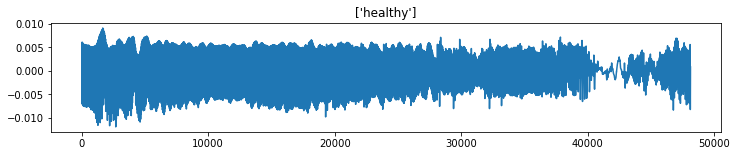

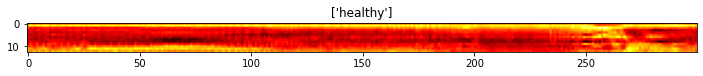

In [49]:
plt.figure(figsize=(12,2))
plt.plot(generated_audio_waves[30])
plt.title(generated_audio_labels[30])
plt.show()
plt.figure(figsize=(12, 2))
plt.imshow(mfcc_features[30].T, cmap='hot')
plt.title(generated_audio_labels[30])
plt.show()

### Pre-processing

In [50]:
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(generated_audio_labels)
print(label_encoded)

[0 0 1 ... 0 1 1]


/home/nextgen/anaconda3/envs/kbs_coin/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [51]:
label_encoded = label_encoded[:, np.newaxis]
label_encoded

array([[0],
       [0],
       [1],
       ...,
       [0],
       [1],
       [1]])

In [52]:
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(label_encoded)
one_hot_encoded

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

### Training(CNN Model)

MinMax Normalization 및 split

In [53]:
X = mfcc_features
y = one_hot_encoded
X = (X-X.min())/(X.max()-X.min())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [54]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

4777개의 training sample, 1195개의 test sample을 확인

In [55]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print(X_test.shape)

(4777, 300, 13, 1)
(1195, 300, 13, 1)


In [59]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), 
    padding='same', input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), 
    padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', 
     optimizer='adam',
     metrics=['acc'])

In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 300, 13, 16)       160       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 300, 13, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 6, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 150, 6, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3686528   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              

In [61]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
150/150 [==============================] - 12s 49ms/step - loss: 0.5676 - acc: 0.6906 - val_loss: 0.3568 - val_acc: 0.8795
Epoch 2/30
150/150 [==============================] - 7s 47ms/step - loss: 0.3449 - acc: 0.8861 - val_loss: 0.3124 - val_acc: 0.8887
Epoch 3/30
150/150 [==============================] - 7s 47ms/step - loss: 0.3129 - acc: 0.9019 - val_loss: 0.3014 - val_acc: 0.9004
Epoch 4/30
150/150 [==============================] - 7s 47ms/step - loss: 0.2959 - acc: 0.9080 - val_loss: 0.2984 - val_acc: 0.9054
Epoch 5/30
150/150 [==============================] - 7s 47ms/step - loss: 0.2801 - acc: 0.9152 - val_loss: 0.2852 - val_acc: 0.9096
Epoch 6/30
150/150 [==============================] - 7s 47ms/step - loss: 0.2749 - acc: 0.9123 - val_loss: 0.2791 - val_acc: 0.9105
Epoch 7/30
150/150 [==============================] - 7s 47ms/step - loss: 0.2717 - acc: 0.9165 - val_loss: 0.2751 - val_acc: 0.9088
Epoch 8/30
150/150 [==============================] - 7s 47ms/step -

loss: 0.14230221509933472
val_loss: 0.3097744584083557


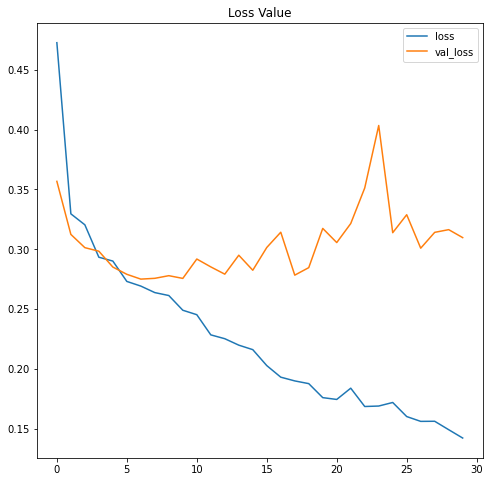

acc: 0.9420138001441956
val_acc: 0.9138075113296509


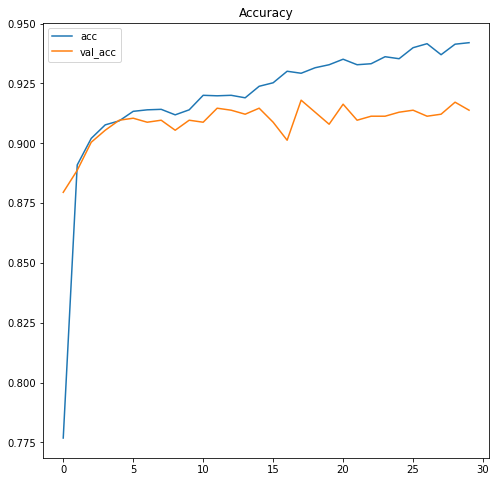

In [69]:
plt.figure(figsize=(8,8))
plt.title('Loss Value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
print('loss:', history.history['loss'][-1])
print('val_loss:', history.history['val_loss'][-1])
plt.show()
plt.figure(figsize=(8,8))
plt.title('Accuracy')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
print('acc:', history.history['acc'][-1])
print('val_acc:', history.history['val_acc'][-1])
plt.show()

에폭이 늘어남에따라 성능에 발전이 없음을 확인했다.

In [70]:
predictions = model.predict(X_test)

In [71]:
predictions = np.argmax(predictions, axis=1)
y_test = one_hot_encoder.inverse_transform(y_test)

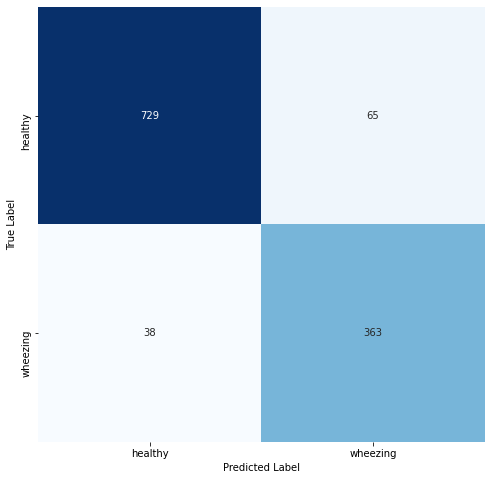

In [72]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### * 결과가 크게 나쁘지는 않지만 에폭이 늘어남에 따라 모델의 성능은 개선되지 않았다. 

#### 이 Pilot Model을 기반으로 좀 더 좋은 성능의 모델을 구축해 보고자 한다.